运用多层感知机MLP(Multi-Layer Perceptron)进行手写数字的识别
MLP的详细介绍：https://www.kesci.com/home/project/5a4f33596fe91734062efc4c

In [2]:
# load the data
# 数据集：MNIST，其包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字

import paddle
import numpy as np
from PIL import Image

BUF_SIZE=512
BATCH_SIZE=128

train_reader = paddle.batch(
    # 每次缓存BUF_SIZE个数据，并且进行打乱
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
                          buf_size=BUF_SIZE),
    # 每BATCH_SIZE个组成一个batch
    batch_size=BATCH_SIZE)
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)

Cache file C:\Users\MEC/.cache/paddle/dataset\mnist\train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file C:\Users\MEC/.cache/paddle/dataset\mnist\train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file C:\Users\MEC/.cache/paddle/dataset\mnist\t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file C:\Users\MEC/.cache/paddle/dataset\mnist\t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


In [4]:
# print data
train_data = paddle.dataset.mnist.train()
sampledata=next(train_data())
print(sampledata)

(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1. 

In [5]:
# MLP模型
# 参考：https://aistudio.baidu.com/aistudio/projectdetail/1099451

import paddle.fluid as fluid

def multilayer_perceptron(input):
    # 第一个全连接层，激活函数为ReLU
    hidden1 = fluid.layers.fc(input=input, size=100, act='relu')
    # 第二个全连接层，激活函数为ReLU
    hidden2 = fluid.layers.fc(input=hidden1, size=100, act='relu')
    # 以softmax为激活函数的全连接输出层，输出层大小为数字的个数10
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax')
    return prediction
# 输入的原始图像数据，大小为1*28*28
image = fluid.layers.data(name='image', shape=[1,28,28], dtype='float32')
# label
label = fluid.layers.data(name='label', shape=[1], dtype='int64')
predict = multilayer_perceptron(image)
# loss,交叉熵损失函数 https://zhuanlan.zhihu.com/p/35709485
cost = fluid.layers.cross_entropy(input=predict, label=label)
avg_cost = fluid.layers.mean(cost)
# 分类准确率
acc = fluid.layers.accuracy(input=predict, label=label)
# 优化函数，使用的是Adam算法 https://blog.csdn.net/luoxuexiong/article/details/90412213
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)
#在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。
#参数初始化操作会被写入fluid.default_startup_program()
#fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

Pass:0, Batch:0, Cost:2.53158, Accuracy:0.09375
Pass:0, Batch:200, Cost:0.31858, Accuracy:0.90625
Pass:0, Batch:400, Cost:0.30079, Accuracy:0.91406
Test:0, Cost:0.22716, Accuracy:0.93167
Pass:1, Batch:0, Cost:0.22677, Accuracy:0.93750
Pass:1, Batch:200, Cost:0.21740, Accuracy:0.96094
Pass:1, Batch:400, Cost:0.14783, Accuracy:0.93750
Test:1, Cost:0.17388, Accuracy:0.94324
save models to D:\_workPlace\Book\AI\CV\MLP\hand.model
----------OVER-----------


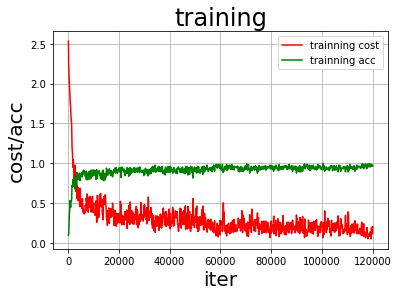

In [9]:
import matplotlib.pyplot as plt
import os

# 模型训练
use_cuda=False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())
# 告知网络传入的数据分为两部分，第一部分是image值，第二部分是label
# DataFeeder负责将数据提供器返回的数据转为一种特殊的数据结构，使其可以输入到Executor
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])
# 绘制模型训练曲线
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]
def draw_train_process(title, iters, costs, accs, label_cost, label_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs, color="red", label=label_cost)#折线图，
    plt.plot(iters, accs, color="green", label=label_acc)
    plt.legend()# 类似图例的效果，https://zhuanlan.zhihu.com/p/111108841
    plt.grid()
    plt.show()
# 训练并保存模型
EPOCH_NUM=2
model_save_dir = r"D:\_workPlace\Book\AI\CV\MLP\hand.model"
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),
                                        fetch_list=[avg_cost, acc])
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        # print info
        if batch_id%200==0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))
    # 进行测试
    test_accs=[]
    test_costs=[]
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(program=test_program,
                                      feed=feeder.feed(data),
                                      fetch_list=[avg_cost, acc])
        test_accs.append(test_acc[0])
        test_costs.append(test_cost[0])
    
    test_cost = sum(test_costs)/len(test_costs)
    test_acc = sum(test_accs)/len(test_accs)
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
#保存模型
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print('save models to %s'%(model_save_dir))
fluid.io.save_inference_model(model_save_dir,
                              ['image'],#推理（inference）需要 feed 的数据
                              [predict],#保存推理（inference）结果的 Variables
                              exe)#executor 保存 inference model
print("----------------------------------OVER-----------------------------------------")
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

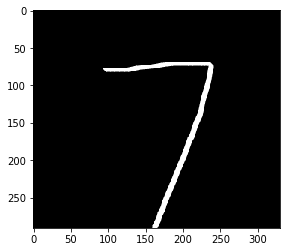

该图片的预测结果的label为: 5


In [27]:
# 模型预测

# 图片预处理,首先进行灰度化，然后压缩图像大小为28*28，接着将图像转换成一维向量，最后再对一维向量进行归一化处理。
def load_image(file):
    im = Image.open(file).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    im = im/255.0*2.0-1.0 # 归一化到【-1~1】之间
    return im

infer_path = r'D:\_workPlace\Book\AI\CV\MLP\test.png'
#显示图片
img = Image.open(infer_path)
plt.imshow(img)
plt.show()
infer_exe = fluid.Executor(place)
inference_scope=fluid.core.Scope()
# 通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。
with fluid.scope_guard(inference_scope):
    [inference_program,
     feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(model_save_dir, infer_exe)
    img = load_image(infer_path)
    results = infer_exe.run(program=inference_program,
                           feed={feed_target_names[0]:img},
                           fetch_list=fetch_targets)
    lab = np.argsort(results)# 获取概率最大的label
    print("该图片的预测结果的label为: %d" % lab[0][0][-1])     #-1代表读取数组中倒数第一列  

In [ ]:
# 测试的图片需要背景全黑，实际使用时准确率较低